# ACLED Data Exploration using Pyspark  

__Taken from ACLED:__ "ACLED collects real-time data on the locations, dates, actors, fatalities, and types of all reported political violence and protest events across Africa, the Middle East, Latin America & the Caribbean, East Asia, South Asia, Southeast Asia, Central Asia & the Caucasus, Europe, and the United States of America."  
LINK for more info: https://acleddata.com/#/dashboard  

##### Data is from January 1st, 2020 through to December 31st, 2020
Dataset file size: 133 mb 

In [94]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.sql.functions import udf
from pyspark.sql import types
from pyspark.ml.feature import StopWordsRemover, Tokenizer, RegexTokenizer

In [95]:
spark = SparkSession.builder.appName("acledPyspark").getOrCreate()

In [96]:
df = spark.read.csv(
    path="/home/jovyan/work/notebooks/datasets/2020-01-01-2020-12-31.csv",
    sep=",",
    quote='"',
    header=True
)
df.show(1)
df.printSchema()

+-------+---+-------------+----------------+----------------+----+--------------+----------+----------------+-------------------+-------------------+------+------+-------------+------+-----------+-----------+-------+-------+----------+------+--------+--------+---------+-------------+-------------------+------------+--------------------+----------+----------+----+
|data_id|iso|event_id_cnty|event_id_no_cnty|      event_date|year|time_precision|event_type|  sub_event_type|             actor1|      assoc_actor_1|inter1|actor2|assoc_actor_2|inter2|interaction|     region|country| admin1|    admin2|admin3|location|latitude|longitude|geo_precision|             source|source_scale|               notes|fatalities| timestamp|iso3|
+-------+---+-------------+----------------+----------------+----+--------------+----------+----------------+-------------------+-------------------+------+------+-------------+------+-----------+-----------+-------+-------+----------+------+--------+--------+--------

### Let's see the shape of the dataframe:

In [97]:
print(df.count(), len(df.columns))

249396 31


### I want to see the "event_date" column as a string. I'll convert to a date object next:

In [98]:
df.select("event_date").show(1)

+----------------+
|      event_date|
+----------------+
|31 December 2020|
+----------------+
only showing top 1 row



### Column transformations

In [99]:
# Change string column types to correct data types: 
df = df.withColumn("event_date", f.to_date("event_date", "dd MMMM yyyy"))
df = df.withColumn("year", f.year(df["year"]))
df = df.withColumn("fatalities", df["fatalities"].cast("int"))
df = df.withColumn("latitude", df["latitude"].cast(types.DoubleType()))
df = df.withColumn("longitude", df["longitude"].cast(types.DoubleType()))
df.printSchema()

root
 |-- data_id: string (nullable = true)
 |-- iso: string (nullable = true)
 |-- event_id_cnty: string (nullable = true)
 |-- event_id_no_cnty: string (nullable = true)
 |-- event_date: date (nullable = true)
 |-- year: integer (nullable = true)
 |-- time_precision: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- sub_event_type: string (nullable = true)
 |-- actor1: string (nullable = true)
 |-- assoc_actor_1: string (nullable = true)
 |-- inter1: string (nullable = true)
 |-- actor2: string (nullable = true)
 |-- assoc_actor_2: string (nullable = true)
 |-- inter2: string (nullable = true)
 |-- interaction: string (nullable = true)
 |-- region: string (nullable = true)
 |-- country: string (nullable = true)
 |-- admin1: string (nullable = true)
 |-- admin2: string (nullable = true)
 |-- admin3: string (nullable = true)
 |-- location: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- geo_precision: 

### Now we can do a groupBy date to see the busiest days in the ACLED dataset: 

In [100]:
# events_per_day 
events_per_day = df.groupBy("event_date").agg(
    f.count("*").alias("events_per_day")
).sort("event_date")
events_per_day.show(5, truncate=False)

+----------+--------------+
|event_date|events_per_day|
+----------+--------------+
|2020-01-01|447           |
|2020-01-02|463           |
|2020-01-03|563           |
|2020-01-04|543           |
|2020-01-05|555           |
+----------+--------------+
only showing top 5 rows



In [101]:
# Converting spark data frame so we can chart it below 
import pandas as pd
events_per_day_pandas_df = events_per_day.toPandas()
events_per_day_pandas_df['event_date'] = pd.to_datetime(events_per_day_pandas_df['event_date'], yearfirst=True)

<AxesSubplot:xlabel='event_date', ylabel='events_per_day'>

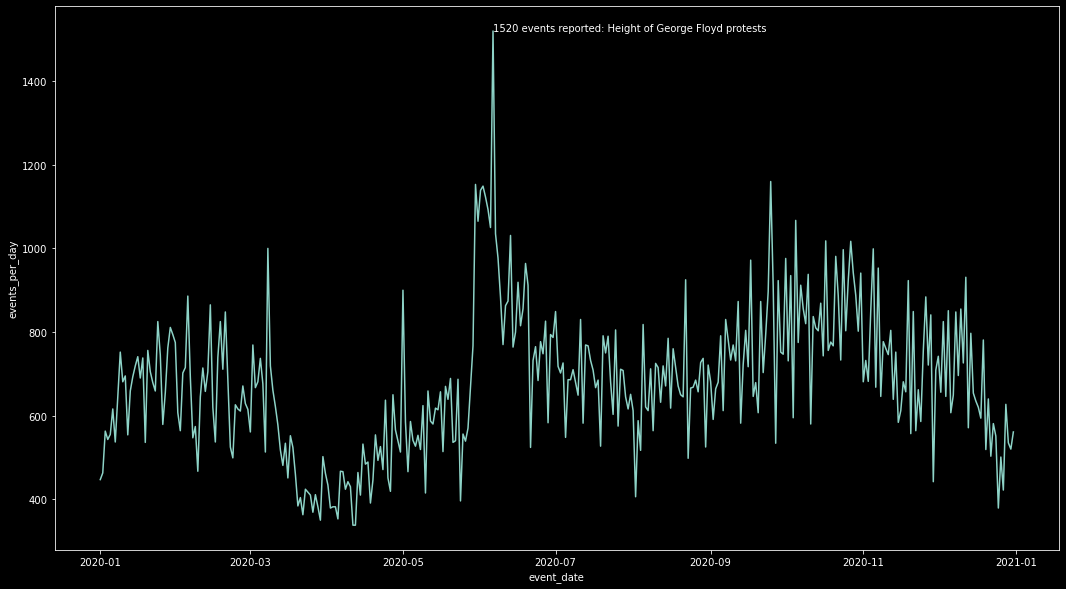

In [102]:
from matplotlib import pyplot 
import numpy as np
import seaborn as sns
pyplot.style.use("dark_background")
fig,ax = pyplot.subplots()
fig.set_size_inches(18, 10)
ax.annotate("1520 events reported: Height of George Floyd protests", xy=(np.datetime64('2020-06-06'),1520))
sns.lineplot(x="event_date", y="events_per_day", data=events_per_day_pandas_df)

### Further analysis on June 6, 2020: grouping the number of events reported on June 6 by country:

In [103]:
df.filter(df.event_date == '2020-06-06') \
.select("country", "event_type") \
.groupBy("country").agg(
    f.count("*").alias("number_of_june_6_events_reported_per_country") 
) \
.sort("number_of_june_6_events_reported_per_country", ascending=False) \
.show(10)

+--------------+--------------------------------------------+
|       country|number_of_june_6_events_reported_per_country|
+--------------+--------------------------------------------+
| United States|                                         745|
|         Italy|                                          93|
|       Germany|                                          66|
|United Kingdom|                                          61|
|        France|                                          45|
|      Pakistan|                                          42|
|         Yemen|                                          36|
|        Mexico|                                          32|
|       Ukraine|                                          28|
|       Lebanon|                                          27|
+--------------+--------------------------------------------+
only showing top 10 rows



### Below shows that most of the ACLED events reported on June 6th, 2020 in the US were of protests: 

In [104]:
df.groupBy("event_date", "country","event_type", ).agg(
    f.count("*").alias("number_of_events_per_type")
) \
.where(df.country == 'United States') \
.where(df.event_date == '2020-06-06') \
.sort("number_of_events_per_type", ascending=False) \
.show(truncate=False)

+----------+-------------+----------------------+-------------------------+
|event_date|country      |event_type            |number_of_events_per_type|
+----------+-------------+----------------------+-------------------------+
|2020-06-06|United States|Protests              |724                      |
|2020-06-06|United States|Strategic developments|12                       |
|2020-06-06|United States|Riots                 |8                        |
|2020-06-06|United States|Battles               |1                        |
+----------+-------------+----------------------+-------------------------+



### Calculating average number of events per day in 2020: 

In [105]:
df.groupBy("event_date").agg(
    f.count("*").alias("total_per_day")
).agg(f.avg(f.col("total_per_day"))).show()

+------------------+
|avg(total_per_day)|
+------------------+
| 681.4098360655738|
+------------------+



### Calculating the deadliest day in 2020 

<AxesSubplot:xlabel='event_date', ylabel='fatalities_per_day'>

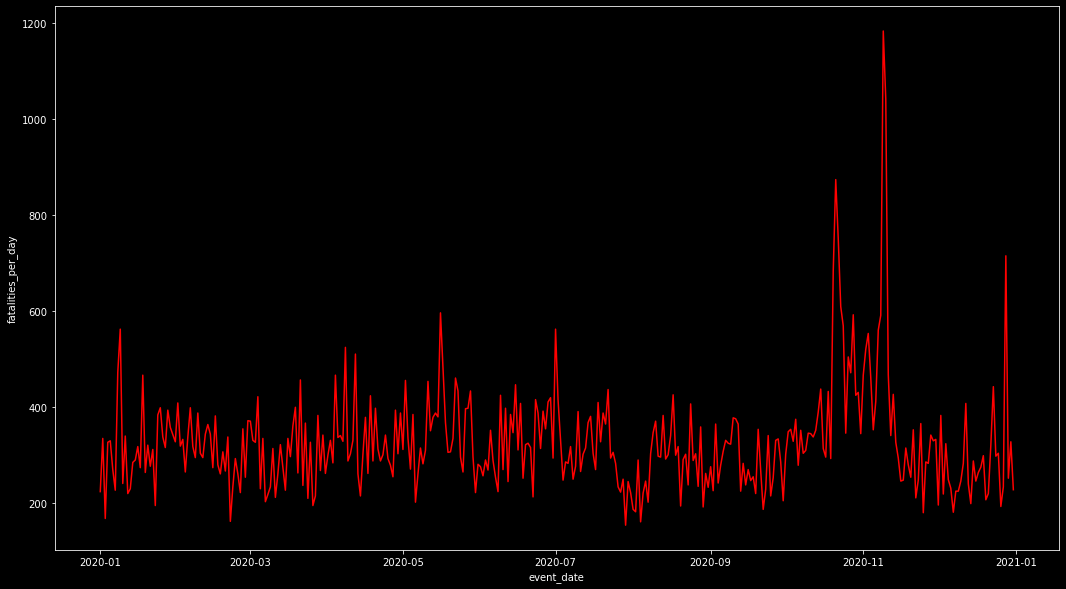

In [106]:
# df.select("year", "fatalities").show()
fatalities_per_day = df.groupBy("event_date").agg(
    f.sum("fatalities").alias("fatalities_per_day")
).sort("event_date") 

# visual to compare events_per_day chart (above)
fatalities_per_day_df = fatalities_per_day.toPandas()
fatalities_per_day_df["event_date"]= pd.to_datetime(fatalities_per_day_df['event_date'], yearfirst=True)

# chart
pyplot.style.use("dark_background")
fig,ax = pyplot.subplots()
fig.set_size_inches(18, 10)

sns.lineplot(x="event_date", y="fatalities_per_day", data=fatalities_per_day_df, color="red")

### Fatalities per country in 2020

In [107]:
fatalities_per_country = df.select("country", "fatalities") \
.groupBy(
    df["country"]
) \
.agg(
    f.sum(df["fatalities"]).alias("fatalities_per_country")
) 
fatalities_per_country \
.select("country", "fatalities_per_country") \
.sort("fatalities_per_country", ascending=False) \
.show(20)

+--------------------+----------------------+
|             country|fatalities_per_country|
+--------------------+----------------------+
|         Afghanistan|                 20901|
|               Yemen|                 19757|
|              Mexico|                  8405|
|               Syria|                  7975|
|             Nigeria|                  7760|
|          Azerbaijan|                  6670|
|Democratic Republ...|                  5766|
|              Brazil|                  4953|
|            Ethiopia|                  3264|
|             Somalia|                  3141|
|                Mali|                  2849|
|                Iraq|                  2708|
|         South Sudan|                  2371|
|        Burkina Faso|                  2298|
|          Mozambique|                  1782|
|            Cameroon|                  1589|
|               Libya|                  1496|
|         Philippines|                  1448|
|               India|            